### Classification of pH range using machine learning

In [1]:
#libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn import preprocessing as pp
import seaborn as sns

In [2]:
# load data
acidoCEST_ML = pd.read_parquet('../clean_data/acido_CEST_MRI_Iopamidol.parquet.gzip')

# drop columns we cannot measure or that are redundant
cols_2_drop = ['ApproT1(sec)','Temp','ExpB0(ppm)','FILE','Conc(mM)']
acidoCEST_ML = acidoCEST_ML.drop(cols_2_drop, axis = 1)

In [3]:
# define experimental columns -- > things we measure other than CEST
exper_cols = [ 'ExpB1(percent)', 'ExpB0(Hz)', 'SatPower(uT)',  'SatTime(ms)','ExpT1(ms)', 'ExpT2(ms)']

In [4]:
# used during development
#acidoCEST_ML  = acidoCEST_ML.sample( n=100)

In [5]:
acidoCEST_ML.shape

(20000, 88)

In [6]:
# Regression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor as RFR

def train_RFR(Xdata, pH_observed):
    print('------------------ Random Forest ------------------ ')
    print()
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
        
        
    # Regression
    param_grid = dict( n_estimators = [50,100], max_depth =[4,8,10,20] )

    # grid parameters
    scorer = metrics.make_scorer( metrics.mean_absolute_percentage_error, greater_is_better=False) 
    estimator = GridSearchCV( RFR(random_state=42, criterion = 'mae', n_jobs = 4), param_grid, verbose = 2, cv = 3, n_jobs= 6, scoring=scorer )

    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)



    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    
    #print(', '.join(Xdata.columns.to_list()))
    print()
    print(m)
   
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Train Random Forest')
    
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Test Random Forest')
    
    print(estimator.best_estimator_)
    
    return estimator.best_estimator_
    
    
def train_lasso(Xdata, pH_observed):
    print('------------------ LASSO ------------------ ')
    print()
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(Xdata, pH_observed, test_size=0.30, random_state=42)
    
    # LASSO
    lasso = linear_model.Lasso( max_iter=5000, random_state=42)

    #pipeline
    pipe = Pipeline(steps=[('Scaler', pp.StandardScaler()), ('lasso', lasso)])

    param_grid ={
            'lasso__alpha': np.linspace(.01,1,20),
            'lasso__fit_intercept': [True,False]
            }

    scorer = metrics.make_scorer( metrics.mean_absolute_percentage_error, greater_is_better=False) 


    estimator = GridSearchCV(pipe, param_grid, verbose = 2, cv = 3, n_jobs= 6, scoring=scorer )


    # fit
    estimator.fit(X_train, y_train)

    score_train = np.round( 100 * metrics.mean_absolute_percentage_error(y_train , estimator.predict(X_train)), 2)
    score_test  = np.round( 100 * metrics.mean_absolute_percentage_error(y_test , estimator.predict(X_test)), 2)

    m = f' mean absolute percentage error \n train = {score_train} % \n test  = {score_test} %'
    
  
    #print(', '.join(Xdata.columns.to_list()))
    print()
    print(m)

    
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_train), y =  y_train)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Train LASSO')
    
    plt.figure()
    sns.regplot(x = estimator.best_estimator_.predict(X_test), y =  y_test)
    plt.xlabel('\n Predicted pH')
    plt.ylabel('Measured pH \n')
    plt.title('Test LASSO')
    
    return estimator.best_estimator_

## 4.2 and 5.6 only

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 8 candidates, totalling 24 fits

 mean absolute percentage error 
 train = 3.19 % 
 test  = 3.6 %
RandomForestRegressor(criterion='mae', max_depth=10, n_jobs=4, random_state=42)
------------------ LASSO ------------------ 

Fitting 3 folds for each of 40 candidates, totalling 120 fits

 mean absolute percentage error 
 train = 3.99 % 
 test  = 4.01 %


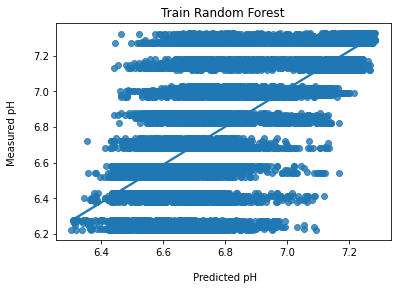

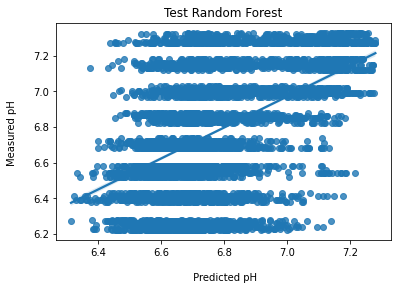

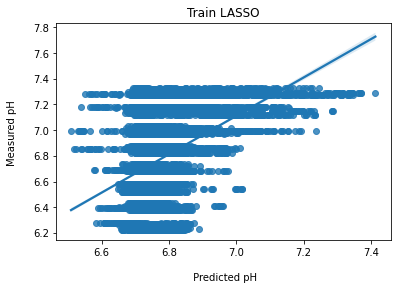

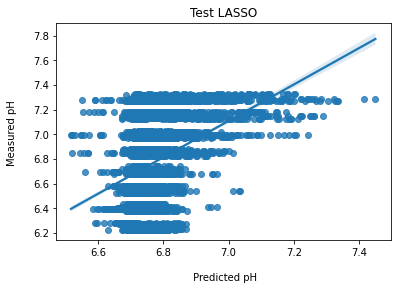

In [7]:
X = acidoCEST_ML[['4.2','5.6']]
Y = acidoCEST_ML.pH

reg_rf = train_RFR(X,Y)
reg_lr = train_lasso(X,Y)

## 4.2 ppm, 5.6 ppm, exp data

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 8 candidates, totalling 24 fits

 mean absolute percentage error 
 train = 0.16 % 
 test  = 0.28 %
RandomForestRegressor(criterion='mae', max_depth=20, n_jobs=4, random_state=42)
------------------ LASSO ------------------ 

Fitting 3 folds for each of 40 candidates, totalling 120 fits

 mean absolute percentage error 
 train = 3.85 % 
 test  = 3.91 %


Pipeline(steps=[('Scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.01, max_iter=5000, random_state=42))])

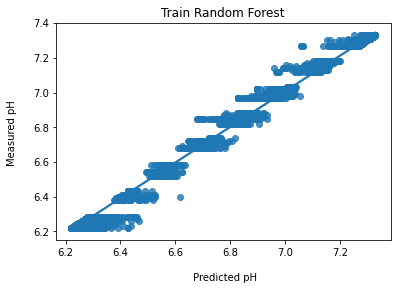

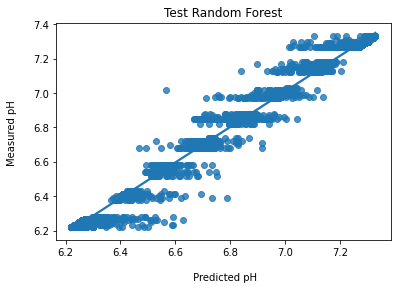

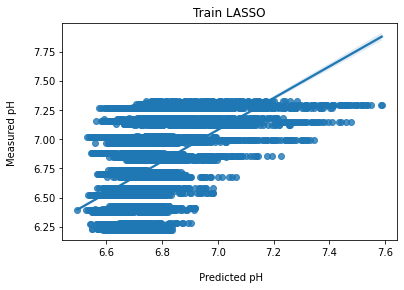

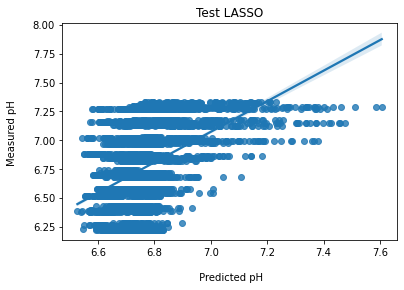

In [8]:
len(['4.2','5.6'] + exper_cols)
c = ['4.2','5.6'] + exper_cols
X = acidoCEST_ML[c]
Y = acidoCEST_ML.pH

train_RFR(X,Y)
train_lasso(X,Y)

# - Only Zspectra

In [ ]:
Xdata = acidoCEST_ML.drop(exper_cols + ['pH'],axis=1)
Ydata = acidoCEST_ML.pH 


train_RFR(Xdata,Ydata)
train_lasso(Xdata,Ydata)

------------------ Random Forest ------------------ 

Fitting 3 folds for each of 8 candidates, totalling 24 fits


# -  Zspectra  + exp data

In [ ]:
Xdata = acidoCEST_ML.drop( ['pH'],axis=1) 
Ydata = acidoCEST_ML.pH


RF    = train_RFR(Xdata,Ydata)
lasso = train_lasso(Xdata,Ydata)

## LASSO COEFF

In [ ]:
reg_lasso = lasso['lasso']

C = pd.DataFrame( reg_lasso.coef_ , columns=['Lasso Coeff'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100)

C[reg_lasso.coef_ != 0].plot(kind='bar', ax = ax)
plt.title('Non-zero Lasso Coefficients \n')
plt.xlabel('\n Feature')
plt.ylabel('Value \n')



## Random Forest, Feature Importance

In [ ]:
I = pd.DataFrame( 100 * RF.feature_importances_, columns=['Importance'], index = Xdata.columns)
_, ax = plt.subplots(dpi = 100, figsize=(16,6))

I.sort_values('Importance').plot(kind='bar', ax = ax, rot=90)

## Feature Selection

In [ ]:
from sklearn.feature_selection import SelectFromModel


In [ ]:
selected_lasso = SelectFromModel( reg_lasso, max_features=20) 
selected_lasso.fit(Xdata, Ydata)
Xdata.columns[selected_lasso.get_support()]

In [ ]:
selected_RF = SelectFromModel( RF  , max_features=20) 
selected_RF.fit(Xdata, Ydata)
Xdata.columns[selected_RF.get_support()]

## Tree Vis

In [ ]:
n_features = []

for i,tree in enumerate( RF.estimators_):
    ft = list( Xdata.columns[ tree.feature_importances_ != 0  ]  )
    n = len(Xdata.columns[ tree.feature_importances_ != 0  ])
    n_non_CEST = sum(['(' in x for x in ft])
    print(f' tree = {i+1} | {n - n_non_CEST} saturation frequencies | {n_non_CEST} non-CEST | total = {n}')
    n_features.append(n)

In [ ]:
%%capture
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


idx = np.argmin(n_features)-1
tree= RF.estimators_[idx]

#classes = list( pd.Series(tree.classes_).replace([0,1],[' pH < 7', 'pH > 7']).values )

fig = plt.figure(dpi=500)
plot_tree( tree,  feature_names = Xdata.columns,
          filled=True, impurity=False,  max_depth = 4, fontsize = 4, label='none', proportion =True,
          rounded=False);

plt.savefig(f'../figs/Tree_example_max_depth_04_tree{idx}_regression.png',bbox_inches='tight')

In [ ]:
from sklearn.tree import export_text

tree_as_text = export_text( tree
                  ,  max_depth = 4
                  ,  decimals = 3
                  ,  spacing = 3
                  , feature_names = list( Xdata.columns  )
                  , show_weights=True )   

In [ ]:
print(tree_as_text)